In [1]:
import torch.nn as nn
import torch
import torch.utils.data as data
from torchvision import datasets,transforms
import numpy as np
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from google.colab import files
from torch.autograd import Variable

Build Generator nn model:

In [2]:
class Generator(nn.Module):
  def __init__(self, img_shape, noise_shape):
    super(Generator,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(noise_shape,128),
        nn.LeakyReLU(0.2,inplace=True),
        
        nn.Linear(128,256),
        nn.BatchNorm1d(256,0.8),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Linear(256,512),
        nn.BatchNorm1d(512,0.8),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Linear(512,1024),
        nn.BatchNorm1d(1024,0.8),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Linear(1024,img_shape),
        nn.Tanh()
       )
  
  def forward(self,x):
    return self.model(x)


Build Discriminator nn model:

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, img_shape):
    super(Discriminator,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(img_shape,512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid(),
        )
    
  def forward(self,x):
    return self.model(x)

Parameters section:

In [ ]:
#running parameters:
n_epochs = 30
batch_size=32
sample_interval=400

#learning parameters:
lr=0.0002
b1=0.5
b2=0.999

# models input/output sizes:
noise_shape=100 
img_size = 28
channels=1


half_batch = int(batch_size/2)
flate_img_shape = img_size*img_size


Initial Part:

- Initaliszed Generator and Discriminator models

- Initial same Loss Criterion for Generator and Discriminator

- Initial train Dataset as DataLoader with batch size = 32

In [ ]:
# Loss function
adversarial_loss = nn.BCELoss(reduction='sum')

# initial models
generator = Generator(flate_img_shape,noise_shape)
discriminator = Discriminator(flate_img_shape)

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [ transforms.ToTensor(),
             transforms.Normalize([0.5], [0.5])]),), batch_size= batch_size,
             shuffle=True)

Declareing Optimazer for Genrator and Discriminator:

In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Traning section
1. train Generator model with the input and targets:

  - randomize 'batch_size' examples with size of 'noise_shape' as input for Generator model

  - Creat target vector with value '1' for labaling the output target for 'real' exmaples

2. Train Discriminator model with the next input and targets:

- randomize half of 'batch_size' examples with size of 'noise_shape' as input for Generator model. taking the output of the generator as a 'fake' example. Then labeling this examples with target of fake examples ('0')

- taking half 'batch_size' examples from training set, labaling this examples with target of 'real' examples ('1')


In [ ]:
for epoch in range(n_epochs):
  for i,(imgs,_) in enumerate(dataloader):
       
        
        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
         # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (batch_size, noise_shape))))
        # Adversarial ground truths
        valid = Variable(Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
        
         # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------


        optimizer_D.zero_grad()

        # Configure input
        real_imgs = Variable(imgs[0:half_batch,:].type(Tensor))
        valid = Variable(Tensor(half_batch, 1).fill_(1.0), requires_grad=False)

        # Generate a batch of images
        z = Variable(Tensor(np.random.normal(0, 1, (half_batch, noise_shape))))
        gen_imgs = generator(z)
        fake = Variable(Tensor(half_batch, 1).fill_(0.0), requires_grad=False)
        

         # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs.data.reshape((half_batch,1,-1))), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
          print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))

          #sample_images(epoch,noise_shape,generator)
          example_imgs = gen_imgs.data[:16]
          fig, axs = plt.subplots(4, 4)
          cnt = 0
          for i in range(4):
              for j in range(4):
                axs[i,j].imshow(example_imgs[cnt, :].detach().numpy().reshape((28,28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
          if (batches_done == 0):
            start_fig = fig;
          fig.savefig("mnist_%d.png" % epoch)
          files.download("mnist_%d.png" % epoch)
          plt.close()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[Epoch 0/30] [Batch 0/1875] [D loss: 6.731756] [G loss: 38.940037]
[Epoch 0/30] [Batch 400/1875] [D loss: 7.517212] [G loss: 31.884203]
[Epoch 0/30] [Batch 800/1875] [D loss: 11.478024] [G loss: 26.479795]
[Epoch 0/30] [Batch 1200/1875] [D loss: 8.418945] [G loss: 33.025288]
[Epoch 0/30] [Batch 1600/1875] [D loss: 7.814410] [G loss: 41.154293]
[Epoch 1/30] [Batch 125/1875] [D loss: 10.271914] [G loss: 43.076664]
[Epoch 1/30] [Batch 525/1875] [D loss: 8.187333] [G loss: 41.714622]
[Epoch 1/30] [Batch 925/1875] [D loss: 8.385545] [G loss: 42.933167]
[Epoch 1/30] [Batch 1325/1875] [D loss: 7.872831] [G loss: 33.786106]
[Epoch 1/30] [Batch 1725/1875] [D loss: 8.077294] [G loss: 28.808468]
[Epoch 2/30] [Batch 250/1875] [D loss: 9.275431] [G loss: 36.224590]
[Epoch 2/30] [Batch 650/1875] [D loss: 8.804481] [G loss: 43.451836]
[Epoch 2/30] [Batch 1050/1875] [D loss: 8.302748] [G loss: 33.824718]
[Epoch 2/30] [Batch 1450/1875] [D loss: 8.186688] [G loss: 41.673664]
[Epoch 2/30] [Batch 1850/187

The Examples the Generator creat at before the training: 

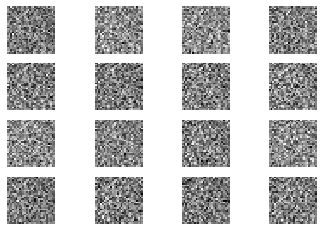

In [ ]:
start_fig

The examples the Generator create after 27 Epochs:

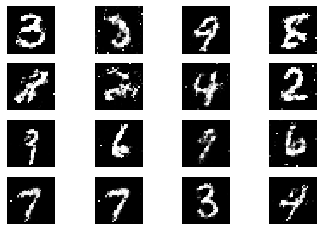

In [ ]:
fig

The examples that Generator model create after 30 Epochs:


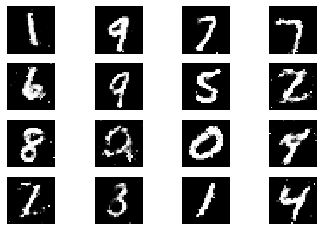

In [ ]:
fig